# Оценка токсичности комментариев

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении имеется набор данных с разметкой о токсичности правок.

Построить модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

    * Для выполнения проекта применять *BERT* необязательно, но можно попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. 

    text - текст комментария, 
    toxic — целевой признак.

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMModel, LGBMRegressor

/Users/mariakuznecova/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


## Загрузка данных

In [2]:
toxic_data = pd.read_csv('/datasets/toxic_comments.csv')
display(toxic_data.info())
display(toxic_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
display(toxic_data[toxic_data['toxic']==1].tail())

,text,toxic
159494,"""\n\n our previous conversation \n\nyou fuckin...",1
159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1
159541,Your absurd edits \n\nYour absurd edits on gre...,1
159546,"""\n\nHey listen don't you ever!!!! Delete my e...",1
159554,and i'm going to keep posting the stuff u dele...,1


Данные успешно загружены. 
Данные представляют собой набор английских текстов со спецсимволами, написанные разными регистрами.

Посмотрим на значения целевого признака.

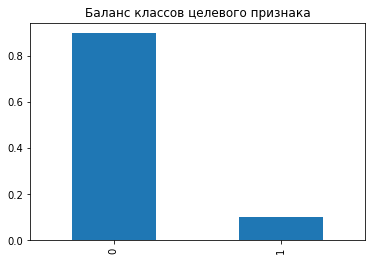

In [4]:
class_frequency = toxic_data['toxic'].value_counts(normalize=True)
class_frequency.plot(kind='bar', title='Баланс классов целевого признака')
plt.show()

В выборке на 9 нормальных комментариев приходится 1 токсичный.

Такое распределение может отрицательно сказаться на обучении моделей и на выполнении предсказаний, так как при обучении отрицательных примеров модель будет получать меньше. Это наблюдение необходимо учесть в дальнейшей работе.

## Подготовка данных
Для работы будем использовать наименее сложные и затратные по времени методы.

Выполним предобработку текста:
   * Очистим текст от лишних символов (оставим только буквы и пробелы).
   * Приведём слова в текстах к единой форме с помощью стемминга, используя SnowballStemmer из библиотеки NLTK.

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariakuznecova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
english_stemmer = SnowballStemmer('english')

def clear_text(text):
    return ' '.join(re.sub(r'[^a-zA-Z ]', ' ', text).split())

def stemm(text):
    stem_text = []
    for word in text.split():
        stem_word = english_stemmer.stem(word)
        stem_text.append(stem_word)

    return ' '.join(stem_text)

In [7]:
%%time

toxic_data['text_cleared'] = toxic_data['text'].apply(clear_text)

toxic_data['text_cleared'] = toxic_data['text_cleared'].apply(stemm)

CPU times: user 2min 23s, sys: 387 ms, total: 2min 23s
Wall time: 2min 24s


In [8]:
display(toxic_data.info())
display(toxic_data.head())
print('Длина до обработки:', len(toxic_data['text'][0]), 'Длина после:', len(toxic_data['text_cleared'][0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   text          159571 non-null  object
 1   toxic         159571 non-null  int64 
 2   text_cleared  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


None

,text,toxic,text_cleared
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero ani chanc you rememb what ...


Длина до обработки: 264 Длина после: 225


Длина текстов уменьшилась за счёт удаления ненужных символов и обрезания окончаний слов при стемминге.

Разобьём данные на обучающую и тестовую выборки.

In [9]:
state = 28
pd.options.display.float_format = '{:,.2f}'.format

train, test = train_test_split(toxic_data, test_size=0.25, random_state=state)

print('Размеры выборки. Обучающая:', len(train), ' , тестовая:', len(test))

Размеры выборки. Обучающая: 119678  , тестовая: 39893


Создадим векторное представление TF-IDF с помощью TfidfVectorizer, дополнительно очистив тексты от стоп-слов.

In [10]:
# original
count_tf_idf_o = TfidfVectorizer(stop_words=stop_words)
tf_idf_o = count_tf_idf_o.fit_transform(train['text'].values.astype('U'))
tf_idf_test_o = count_tf_idf_o.transform(test['text'].values.astype('U'))

In [11]:
# stemmed
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit_transform(train['text_cleared'].values.astype('U'))
tf_idf_test = count_tf_idf.transform(test['text_cleared'].values.astype('U'))

## Вывод
Данные успешно загружены и рассмотрены.

В целевом признаке наблюдаем сильный дисбаланс классов.

Набор текстов очищен от лишних символов, создано два векторных представления признаков для дальнейшего использования при обучении и предсказании: на исходном тексте, на очищенном тексте.

# 2. Обучение
Возьмём модель логистической регрессии. На обучающей выборке выполним кросс-валидацию.

Для учёта дисбаланса классов используем параметр class_weight = 'balanced'.

Соберём данные по работе моделей в сводную таблицу.

In [12]:
final_table = pd.DataFrame(columns=['f1', 't_p', 't_n'])

In [13]:
# красиво представим результаты тестирования
def scores(y_true, y_pred, model):
    f1 = f1_score(y_true, y_pred)
    print('Значение F1 на тестовой выборке:', f1)
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(
        figsize=(3,1))

    sns.heatmap(cm, annot=True, fmt=".0f", cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Матрица ошибок')
    plt.show()
    final_table.loc[model, 'f1'] = f1
    final_table.loc[model, 't_p'] = cm[0][0]
    final_table.loc[model, 't_n'] = cm[1][1]
    return

### Модель на исходных текстах

In [14]:
model_o = LogisticRegression(random_state = state, solver='lbfgs', max_iter = 200, class_weight = 'balanced')
final_score = cross_val_score(model_o, tf_idf_o, train['toxic'], cv=5, scoring='f1').sum() / 5
final_score

0.7485804119735637

In [15]:
model_o.fit(tf_idf_o, train['toxic'])

LogisticRegression(class_weight='balanced', max_iter=200, random_state=28)

Значение F1 на тестовой выборке: 0.7527520915896081


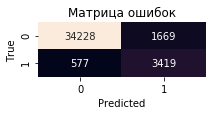

In [16]:
predictions_test = model_o.predict(tf_idf_test_o)
scores(test['toxic'], predictions_test, 'original')

### Модель на предобработанных текстах

In [17]:
model_s = LogisticRegression(random_state = state, solver='lbfgs', max_iter = 200, class_weight = 'balanced')
final_score = cross_val_score(model_s, tf_idf, train['toxic'], cv=5, scoring='f1').sum() / 5
final_score

0.7489640206407786

In [18]:
model_s.fit(tf_idf, train['toxic'])

LogisticRegression(class_weight='balanced', max_iter=200, random_state=28)

In [19]:
predictions_test = model_s.predict(tf_idf_test)

Значение F1 на тестовой выборке: 0.754758020663404


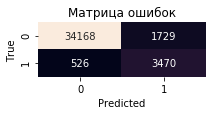

In [20]:
scores(test['toxic'], predictions_test, 'stemmed')

Несмотря на то, что показатель F1-меры довольно близок у этих двух моделей, модели, обученной на предобработанных данных удалось немного лучше предсказать класс 1, т.е. токсичные комментарии.

### Увеличение выборки

In [21]:
features_zeros = train['text_cleared'][train['toxic'] == 0]
features_ones = train['text_cleared'][train['toxic'] == 1]
target_zeros = train['toxic'][train['toxic'] == 0]
target_ones = train['toxic'][train['toxic'] == 1]
    
repeat = np.ceil(target_zeros.shape[0] / target_ones.shape[0]).astype('int')


def upsample(features, target, repeat):
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=state)
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(train['text_cleared'], train['toxic'], repeat)
corpus_upsampled = features_upsampled.values.astype('U')

count_tf_idf_up = TfidfVectorizer(stop_words=stop_words)
tf_idf_up = count_tf_idf_up.fit_transform(corpus_upsampled)




In [22]:
model_upsample = LogisticRegression(random_state = state, max_iter = 200, class_weight = 'balanced')
final_score = cross_val_score(model_upsample, tf_idf_up, target_upsampled, cv=5, scoring='f1').sum() / 5
display(final_score)

0.9572324470871456

Значение F1 на тестовой выборке: 0.6756608533508829


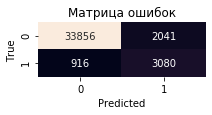

In [23]:
tf_idf_up_test = count_tf_idf_up.transform(test['text'])
model_upsample.fit(tf_idf_up, target_upsampled)
predictions_test = model_upsample.predict(tf_idf_up_test)
scores(test['toxic'], predictions_test, 'upsampled')

Вопреки ожиданиям у модели, обучавщейся на увеличенной выборке, хуже предсказания.

### Модель градиентного бустинга

In [24]:
model_lgb = lgb.LGBMClassifier(random_state=state, class_weight = 'balanced')
final_score = cross_val_score(model_lgb, tf_idf, train['toxic'], cv=5, scoring='f1').sum() / 5
display(final_score)

0.7421772641096822

In [25]:
model_lgb.fit(tf_idf, train['toxic'])

LGBMClassifier(class_weight='balanced', random_state=28)

In [26]:
predictions_test = model_lgb.predict(tf_idf_test)

Значение F1 на тестовой выборке: 0.740924464487035


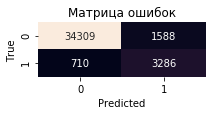

In [27]:
scores(test['toxic'], predictions_test, 'lgb')

Полученная модель градиентного бустинга лучше по сравнению с двумя предыдущими моделями предсказывает обычные комментарии, но хуже - токсичные комментарии.
## Вывод
Были обучены 4 модели. Только две из них смогли на тестовой выборке показать значение F1 не меньше порогового 0.75.

# 3. Выводы

Перед началом работы мы получили набор текстов с пометкой о негативном смысле данного текста.

Тексты были предобработаны и переведены в векторную форму TF-IDF, которая учитывает частоту употребления слова в тексте в зависимости от общего количества употреблений данного слова во всех текстах. Это значит, что наша модель будет смотреть будет оценивать тональность комментария по тому, как часто в тексте встречаются слова из токсичных комментариев.

Рассмотрим полученную сводную таблицу по работе моделей.

In [28]:
final_table.sort_values(by='f1', ascending=False)

,f1,t_p,t_n
stemmed,0.75,34168,3470
original,0.75,34228,3419
lgb,0.74,34309,3286
upsampled,0.68,33856,3080


Были построены 4 модели:
* логистическая регрессия на исходных данных;
* логистическая регрессия на предобработанных данных;
* логистическая регрессия на увеличенной выборке для предобработанных данных;
* градиентный бустинг на предобработанных данных.

Худший результат на тестовой выборке показала логистическая регрессия на увеличенной выборке для предобработанных данных. Объяснить это можно тем, что хоть модели и показывали больше примеров с токсичными комментариями, но эти комментарии содержали ограниченный набор слов. А в тестовой выборке встречались токсичные комментарии с другим набором слов.

Модель градиентного бустинга лучше других предсказывает нетоксичные комментарии, но, при этом, токсичные комментарии угадывает хуже логистических регрессий на обычных данных и на предобработанных.

Лучшей моделью по значению F1 оказалась модель логистической регрессии на предобработанных данных: она лучше других предсказывает негативные комментарии.

Возможно, если бы в работе использовались более сложные и затратные по времени методики предподготовки и векторизации текстов, результат был бы выше.

Поскольку в результате данной работы была достигнута метрика F1 = 0.75, интернет-магазину «Викишоп» предлагается воспользоваться моделью логистической регрессии на предобработанных данных, как наиболее точно угадавыющей негативные комментарии.